# **Getting them stonks: Portfolio optimization with the Mean-Variance framework**
---

## Contents:

>[1 - Introduction](#1---Introduction)
>
>[2 - Importing modules](#2---Importing-modules)
>
>[3 - Data retrieval](#3---Data-retrieval)
>
>[4 - Preprocessing](#4---Preprocessing)
>
>[5 - Modelling](#5---Modelling)
>
>[6 - Conclusion](#6---Conclusion)
>


## 1 - Introduction

### **Scenario:** You won the lottery, recieved the paycheck for your summer internship, or that distant uncle you didn't even know passed and left you some money... what do you do?
### **A:** Invest... but how?

Recipe for investment:

1. Define a goal/strategy
2. Pick suitable assets
3. **Construct a suitable portfolio**
4. Check and repeat

### **Q:** Given $n$ assets, what is the optimal allocation of these within a portfolio?
### **A:** There are many...

### The Mean-Variance framework:
- Developed by Harry Markowitz in 1952 (earned him Nobel Price in Economics)
- Aims to solve the above problem using two ingredients:
    1. The volatility of asset returns (risk) - for stocks, this is the average log first difference in stock prices
    2. The expected asset returns (reward) - for stocks, this is the sample covariance of periodic returns
- Shortcomings:
    - Stock returns can be non-stationary $\implies$ we can't use average returns as a reasonable forecast
    - Stock returns are notoriously hard to forecast (Efficient Market Hypothesis)
    
### Goal: Using the M-V framework, find the optimal fraction of the total portfolio for each asset
    

## 2 - Importing modules

In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

# Declaring standard Seaborn color palette
standard_palette = []
for i in range(10):
    standard_palette += list(sns.color_palette('muted'))
    

from random import seed
from random import random

seed(1)
%matplotlib inline

## 3 - Data retrieval

First, we need to gather data on stock prices for a selection of assets. We focus our attention on [Russell 1000 Index](https://en.wikipedia.org/wiki/Russell_1000_Index) during the period Feb 2019 - Feb 2021.

In [2]:
# Specify asset symbols
stocks = ['GOOG', 'AAPL', 'FB', 'BABA', 'AMZN', 'GE', 'AMD', 'WMT', 'BAC', 'GM',
'T', 'UAA', 'SHLD', 'XOM', 'RRC', 'BBY', 'MA', 'PFE', 'JPM', 'SBUX']
data = web.DataReader(stocks, 'yahoo', start='2018/02/10', end='2021/02/10')
data.head()

Attributes    Adj Close                                                  \
Symbols            GOOG       AAPL          FB        BABA         AMZN   
Date                                                                      
2018-02-12  1051.939941  39.245506  176.410004  177.440002  1386.229980   
2018-02-13  1052.099976  39.638657  173.149994  179.250000  1414.510010   
2018-02-14  1069.699951  40.369492  179.520004  186.759995  1451.050049   
2018-02-15  1089.520020  41.725037  179.960007  187.449997  1461.760010   
2018-02-16  1094.800049  41.589962  177.360001  183.679993  1448.689941   

Attributes                                                     ...  \
Symbols            GE    AMD        WMT        BAC         GM  ...   
Date                                                           ...   
2018-02-12  13.732266  11.68  93.746681  29.098061  38.254375  ...   
2018-02-13  13.593276  11.78  95.093338  29.154165  37.707878  ...   
2018-02-14  13.806396  12.20  95.771339  29.920889  38.081322  ...   
2018-02-15  13.760066  12.19  97.212181  30.117243  38.117744  ...   
2018-02-16  13.945387  11.82  98.671799  29.892838  37.425522  ...   

Attributes      Volume                                                      \
Symbols              T         UAA SHLD         XOM         RRC        BBY   
Date                                                                         
2018-02-12  27750700.0  12275300.0  NaN  19340400.0   8504700.0  3257700.0   
2018-02-13  22877200.0  34064200.0  NaN  11926600.0   5099600.0  2881600.0   
2018-02-14  24834200.0  19153300.0  NaN  17188400.0   9274100.0  3602700.0   
2018-02-15  27507200.0  13702600.0  NaN  14432400.0  11773300.0  2283900.0   
2018-02-16  19901600.0  13755300.0  NaN  13722400.0   7499300.0  2165700.0   

Attributes                                                 
Symbols            MA         PFE         JPM        SBUX  
Date                                                       
2018-02-12  5227400.0  38743670.0  18043300.0  10969000.0  
2018-02-13  3471000.0  21559570.0  16358200.0  10416400.0  
2018-02-14  4203700.0  24494749.0  15186900.0  14190300.0  
2018-02-15  3915000.0  22588379.0  12130200.0  10294900.0  
2018-02-16  4213100.0  27659595.0  13214300.0  10151300.0  

[5 rows x 120 columns]

In [3]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2018-02-12 to 2021-02-10
Columns: 120 entries, ('Adj Close', 'GOOG') to ('Volume', 'SBUX')
dtypes: float64(120)
memory usage: 713.7 KB


## 4 - Preprocessing

In [4]:
data = data['Adj Close']
data.head()

Symbols,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,WMT,BAC,GM,T,UAA,SHLD,XOM,RRC,BBY,MA,PFE,JPM,SBUX
Date,,,,,,,,,,,,,,,,,,,,
2018-02-12,1051.939941,39.245506,176.410004,177.440002,1386.229980,13.732266,11.68,93.746681,29.098061,38.254375,30.105310,14.230000,NaN,64.415543,12.799002,64.917915,165.515198,29.364902,102.015762,52.114552
2018-02-13,1052.099976,39.638657,173.149994,179.250000,1414.510010,13.593276,11.78,95.093338,29.154165,37.707878,30.295685,16.700001,NaN,64.314377,12.485156,64.687233,167.414520,29.602127,102.645706,52.387455
2018-02-14,1069.699951,40.369492,179.520004,186.759995,1451.050049,13.806396,12.20,95.771339,29.920889,38.081322,30.138416,17.760000,NaN,64.449257,12.887270,66.920364,169.776367,29.813931,105.019440,52.688583
2018-02-15,1089.520020,41.725037,179.960007,187.449997,1461.760010,13.760066,12.19,97.212181,30.117243,38.117744,30.626795,18.410000,NaN,64.238518,13.367846,67.658592,171.911850,30.254484,105.457664,53.243801
2018-02-16,1094.800049,41.589962,177.360001,183.679993,1448.689941,13.945387,11.82,98.671799,29.892838,37.425522,30.742676,17.360001,NaN,64.516693,13.024577,67.529411,172.856552,30.720463,104.699898,53.149685


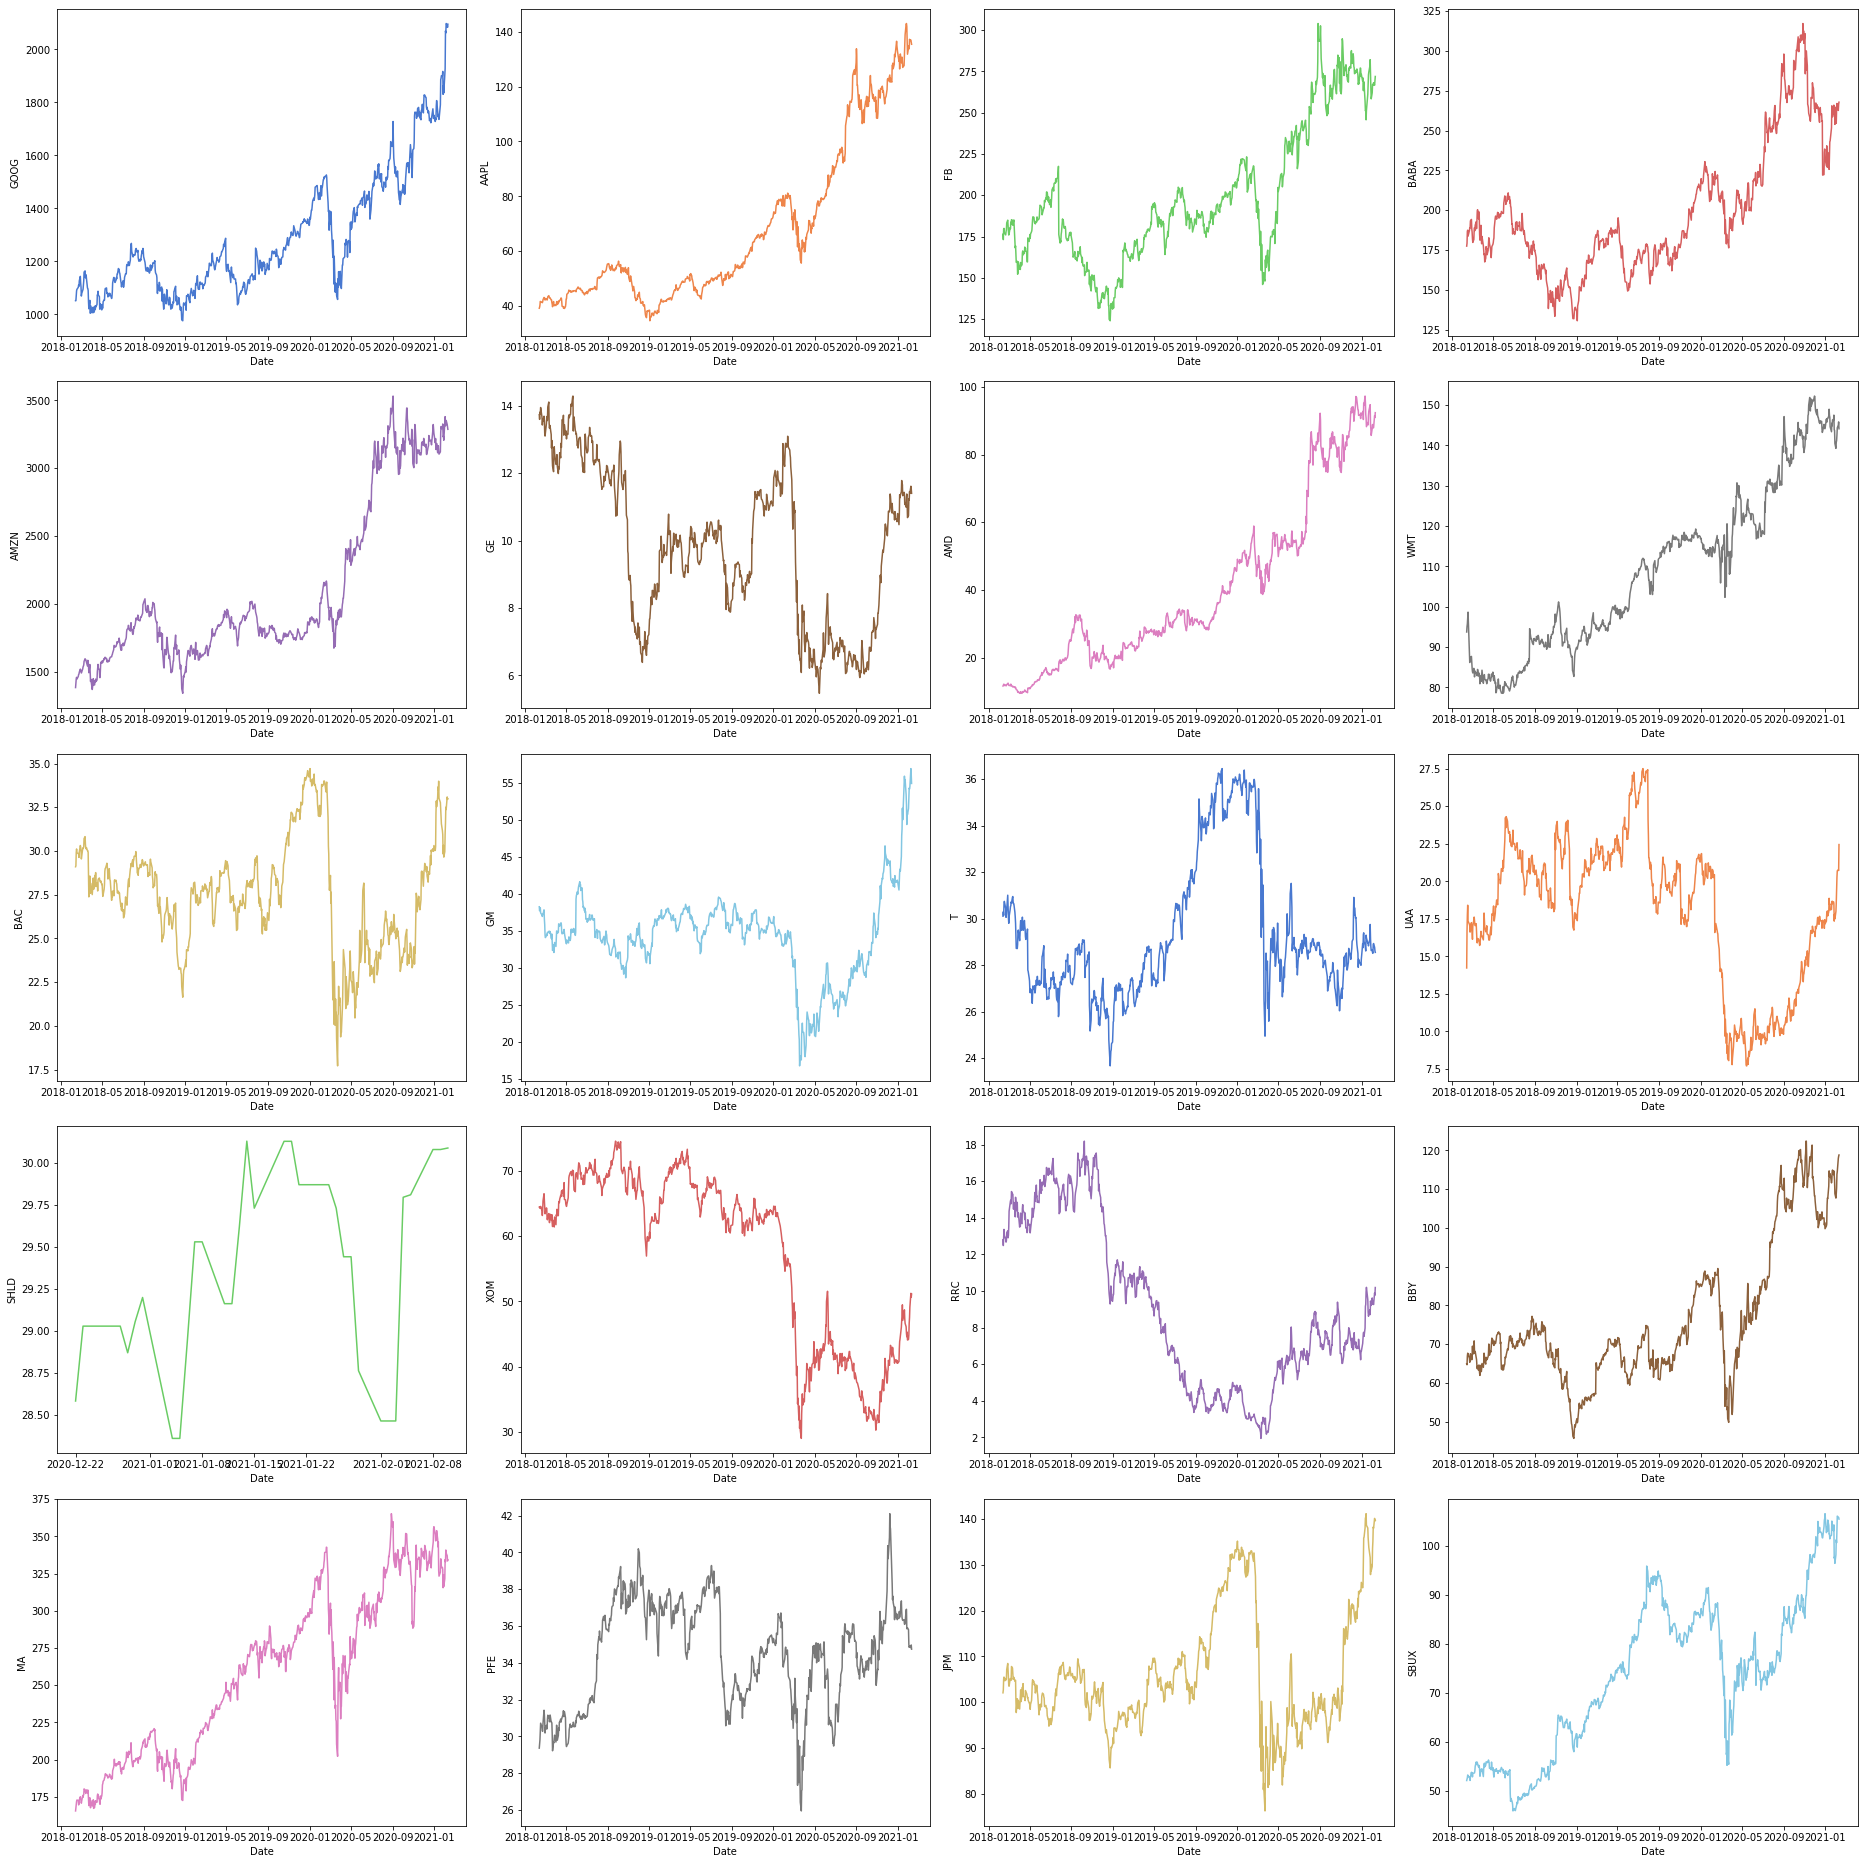

In [5]:
fig, axs = plt.subplots(5,4)
fig.set_size_inches(26, 26)
for i in range(20):
    sns.lineplot(data=data.iloc[:, i].dropna(), 
                ax=axs[i//4, i % 4],
                color=standard_palette[i])

plt.tight_layout()

In [6]:
returns = (np.log(data)).diff()
returns.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2018-02-12 to 2021-02-10
Columns: 20 entries, GOOG to SBUX
dtypes: float64(20)
memory usage: 123.9 KB


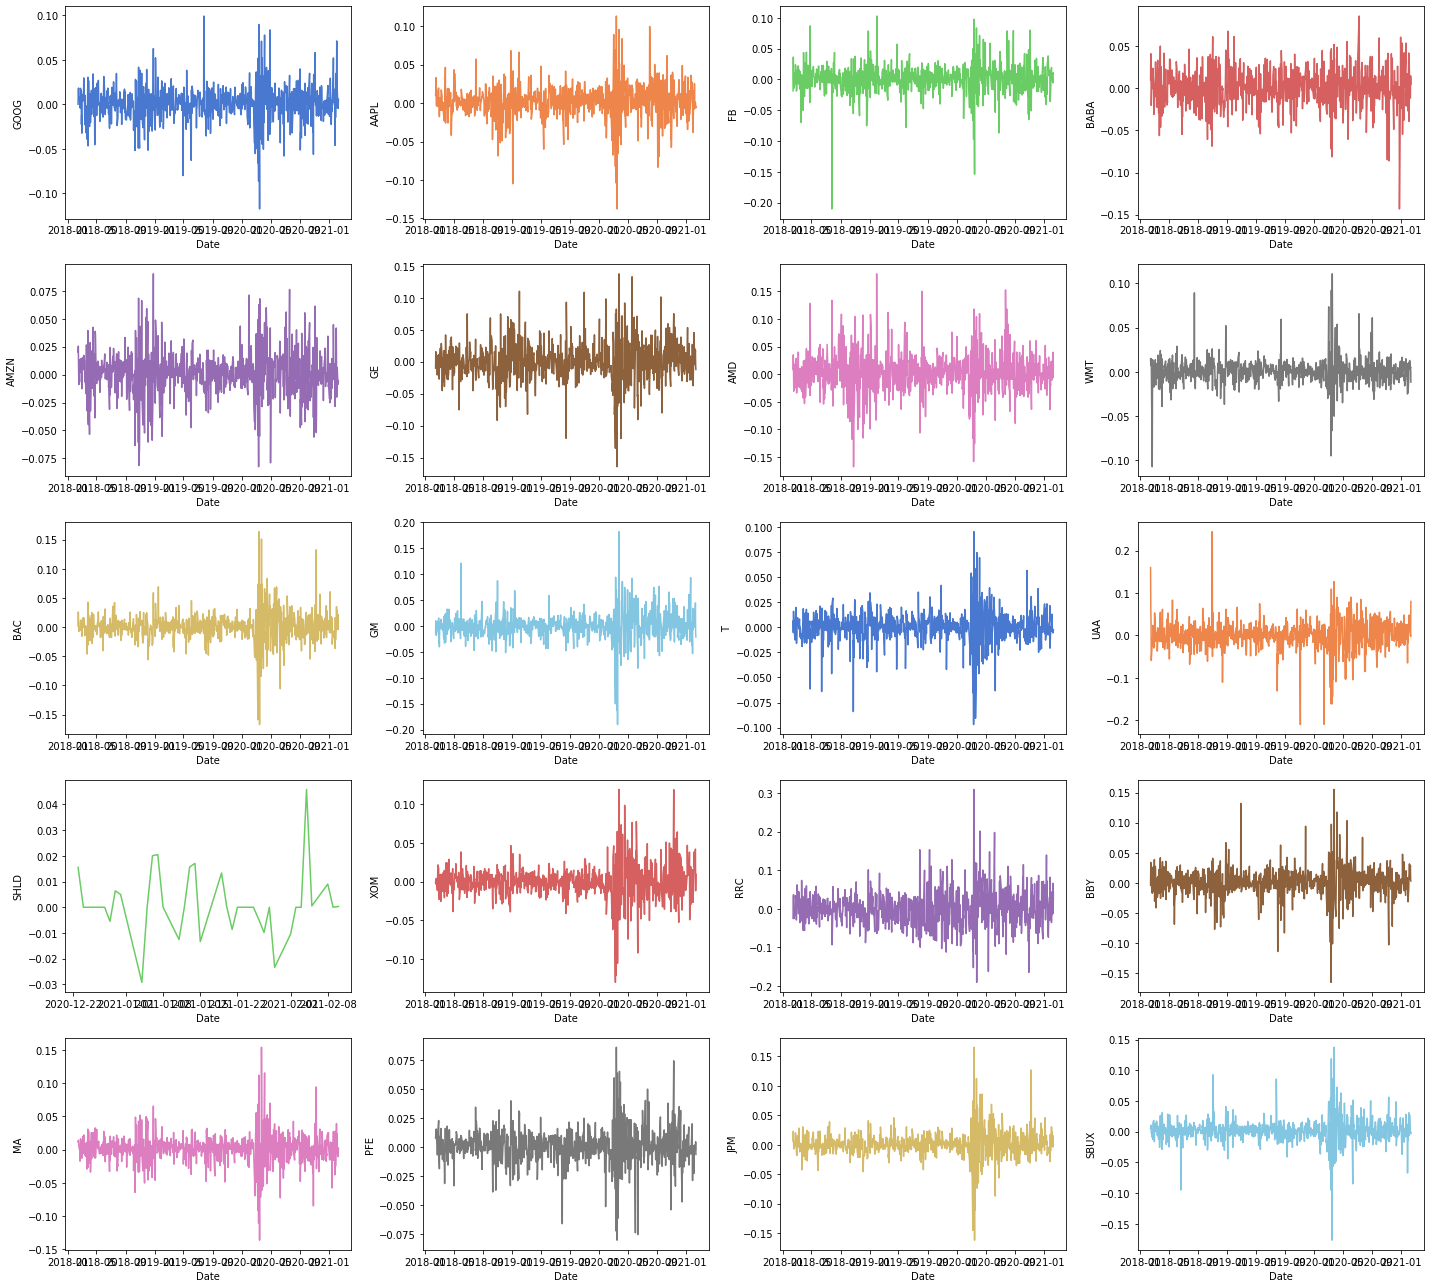

In [7]:
fig, axs = plt.subplots(5,4)
fig.set_size_inches(20, 18)
for i in range(20):
    sns.lineplot(data=returns.iloc[:, i].dropna(), 
                ax=axs[i//4, i % 4],
                color=standard_palette[i])
    
plt.tight_layout()

In [8]:
ex_returns = returns.mean()
cov_returns = returns.cov()

## 5 - Modelling

#### Goal:

$W=\begin{bmatrix}
w_1\\
\vdots \\
w_n
\end{bmatrix}$

#### Ingredients:

#### $R=\begin{bmatrix}
\mathbb{E}[r_1]\\
\vdots \\
\mathbb{E}[r_n]
\end{bmatrix} \quad,\quad\Sigma = \begin{bmatrix}
\sigma_{11} & \dots & \sigma_{n1}\\
\vdots & \ddots & \vdots\\
\sigma_{1n} & \dots & \sigma_{nn}
\end{bmatrix}$

#### Plan of Attack:
1. Define our objective function
2. OPTIMIZE!
3. Analyze solutions

In [9]:
# Defining weights vector
n = 20
w = cp.Variable(n)

# Defining solutions dictionary
solutions = {}

### Model 1: Minimum volatility

#### $ \underset{W}{\text{min}} \quad  W^T\:\Sigma \: W$
#### $\textrm{s.t}\quad \sum_{i=1}^{n}{w_i}=1 \quad , \quad w_i\geq 0$


In [10]:
# Creating objective function and constraints
objective = cp.quad_form(w, cov_returns)
constraints = [w>=0,                    # no short-selling constraint
               (np.ones(n))@w == 1]     # market-neutral constraint

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()
solutions['Model 1'] = w.value

# Print result
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)



The optimal value is 9.256084900256532e-05
Solution weight is
[ 8.04301996e-20 -4.42312310e-20 -2.46292153e-20  1.47909929e-03
  7.31886637e-02  7.78258322e-20  4.45422599e-19  2.03385999e-01
  1.46182880e-19  2.33902157e-20  7.21616839e-02  1.04343100e-18
  4.43665088e-01 -7.46483694e-20  1.00250590e-02  4.75051414e-19
  1.48434916e-19  1.96094407e-01  1.29642841e-19 -9.89679391e-20]


### Model 2: Minimum volatility (with short-selling)

#### $ \underset{W}{\text{min}} \quad  W^T\:\Sigma \: W$
#### $\textrm{s.t}\quad \sum_{i=1}^{n}{w_i}=1$


In [11]:
# Creating objective function and constraints
objective = cp.quad_form(w, cov_returns)
constraints = [(np.ones(n))@w == 1]     # market-neutral constraint

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Print result
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)


The optimal value is 6.040087943632264e-05
Solution weight is
[ 0.02969358 -0.17657919  0.06600034  0.00485073  0.10260165 -0.01835381
  0.00985755  0.10209209 -0.40431858 -0.08346637  0.25105293  0.02612928
  0.62793249 -0.08555154  0.06841507  0.0234031   0.05404727  0.21375725
  0.20875912 -0.02032296]


### Model 3: Risk-efficient

#### $ \underset{W}{\text{min}} \quad  W^T\:\Sigma \: W $
#### $\textrm{s.t}\quad R^T\!W \geq \mu \quad , \quad \sum_{i=1}^{n}{w_i}=1\quad , \quad w_i\geq 0$

In [12]:
# Defining target return rate in (0,0.25]
mu = (random())/4

# Creating objective function and constraints
objective = cp.quad_form(w, cov_returns)
constraints = [(ex_returns.to_numpy())@w >= mu,      # target return constraint
               (np.ones(n))@w == 1]     # market-neutral constraint

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Print result
print('Target return rate: ', mu)
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)

Target return rate:  0.033591061028100305

The optimal value is 0.042524851755817925
Solution weight is
[ 1.63003037  3.84040631 -2.64611619 -3.44355245 -0.17666404 -1.1783761
  3.00333609 -3.17720428 -7.81297472 -0.49206424 -2.77516342  1.2606544
 10.32389042 -6.48013844  1.20275185 -0.35892253  3.09272972 -2.02941557
  6.48061544  0.7361774 ]


### Model 4: Return-efficient

#### $ \underset{W}{\text{max}} \quad R^T\!W$
#### $\textrm{s.t}\quad W^T\:\Sigma \: W \leq \sigma^2 \quad , \quad \sum_{i=1}^{n}{w_i}=1 \quad , \quad w_i\geq 0$

In [13]:
# Defining target volatility in (0,0.1]
sigma_sq = (random())/10

# Creating objective function and constraints
objective = cp.quad_form(w, cov_returns)
constraints = [(ex_returns.to_numpy())@w <= sigma_sq,      # target return constraint
               (np.ones(n))@w == 1]     # market-neutral constraint

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Print result
print('target volatility: ', sigma_sq)
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)

target volatility:  0.08474337369372327

The optimal value is 6.040087943632264e-05
Solution weight is
[ 0.02969358 -0.17657919  0.06600034  0.00485073  0.10260165 -0.01835381
  0.00985755  0.10209209 -0.40431858 -0.08346637  0.25105293  0.02612928
  0.62793249 -0.08555154  0.06841507  0.0234031   0.05404727  0.21375725
  0.20875912 -0.02032296]


### Model 5: Maximum Sharpe Ratio *
#### $ \underset{W}{\text{max}} \frac{R^T\!W - r_f}{\sqrt{W^T\:\Sigma \: W}}$
#### $\textrm{s.t}\quad \sum_{i=1}^{n}{w_i}=1 \quad , \quad w_i\geq 0$

### ...
### STOP!!! THIS IS NOT A CONVEX PROBLEM

#### Assume $\quad \exists \; W: \; R^TW \; -  \; r_f \geq 0 $           (not unreasonable)


#### $\implies \underset{y,\kappa}{\text{min}} \quad  y^T\:\Sigma \: y $
#### $\quad \textrm{s.t}\quad \sum_{i=1}^{n}{(r_i-r_f)y_i}=1 \quad , \quad \sum_{i=1}^{n}{y_i}=\kappa \quad , \quad w_i\geq 0$

## 6 - Analysis

             Returns     Volatility   GOOG weight   AAPL weight     FB weight  \
count  100000.000000  100000.000000  1.000000e+05  1.000000e+05  1.000000e+05   
mean        0.000666       0.016097  4.992259e-02  4.992303e-02  4.989408e-02   
std         0.000096       0.000650  2.888285e-02  2.881826e-02  2.881594e-02   
min         0.000293       0.012983  7.215379e-07  4.809995e-09  6.256722e-09   
25%         0.000601       0.015654  2.562690e-02  2.566756e-02  2.555214e-02   
50%         0.000666       0.016084  4.994373e-02  4.986160e-02  4.981464e-02   
75%         0.000731       0.016525  7.304880e-02  7.309806e-02  7.304339e-02   
max         0.001075       0.019680  1.628317e-01  1.597572e-01  1.724793e-01   

        BABA weight   AMZN weight     GE weight    AMD weight    WMT weight  \
count  1.000000e+05  1.000000e+05  1.000000e+05  1.000000e+05  1.000000e+05   
mean   5.012540e-02  5.019518e-02  4.995322e-02  5.017431e-02  4.978577e-02   
std    2.881876e-02  2.882165e-02

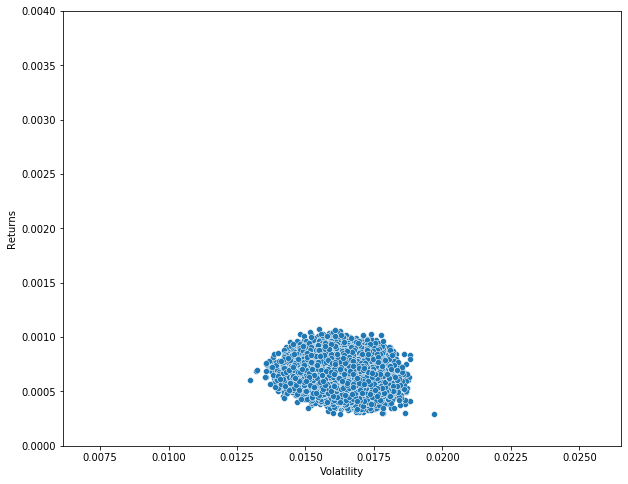

In [14]:
# Monte Carlo simultions of different portfolios

p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatilities
p_weights = [] # Define an empty array for asset weights
num_portfolios = 500

for portfolio in range(num_portfolios):
    weights = np.random.random(n)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = (ex_returns.to_numpy())@weights 
    volatility =  (weights@cov_returns@weights)**0.5
    p_ret.append(returns)
    p_vol.append(volatility)
simulations = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(data.columns.tolist()):
    simulations[symbol+' weight'] = [w[counter] for w in p_weights]
    
simulated_portfolios  = pd.DataFrame(simulations)

f, axs = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=simulated_portfolios,x=simulated_portfolios['Volatility'], 
                y=simulated_portfolios['Returns'], ax=axs)
plt.ylim(0, 0.004)

plt.show()

## 7 - References
